In [152]:
import re
import io
import requests
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
sc.settings.set_figure_params(dpi=80)

In [153]:
text = open('/Users/paulo.barenco/Box/repos/workshop-scRNAseq/labs/r_labs/knit_labs.Rmd')
text = text.readlines()
def l(x,text,lab='SCANPY'):
    return([re.sub('#'+x+'_'+lab+':|\n','',line) for line in text if re.search('#'+x+'_'+lab+':',line)])

***

# {{ l('DATA',text,'TITLE')[0] }}

{{ l('DATA',text,'ALL1')[0] }}

In [154]:
!mkdir data
!curl -o data/pbmc_1k_v2_filtered_feature_bc_matrix.h5 -O http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_v2/pbmc_1k_v2_filtered_feature_bc_matrix.h5
!curl -o data/pbmc_1k_v3_filtered_feature_bc_matrix.h5 -O http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_v3/pbmc_1k_v3_filtered_feature_bc_matrix.h5
!curl -o data/pbmc_1k_protein_v3_filtered_feature_bc_matrix.h5 -O http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_protein_v3/pbmc_1k_protein_v3_filtered_feature_bc_matrix.h5

mkdir: data: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3349k  100 3349k    0     0  14.8M      0 --:--:-- --:--:-- --:--:-- 14.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5234k  100 5234k    0     0  36.7M      0 --:--:-- --:--:-- --:--:-- 36.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5336k  100 5336k    0     0  35.4M      0 --:--:-- --:--:-- --:--:-- 35.6M


{{ l('DATA',text,'ALL2')[0] }}

{{ l('DATA',text,'ALL3')[0] }}

In [155]:
data_p3 = sc.read_10x_h5(
    'data/pbmc_1k_protein_v3_filtered_feature_bc_matrix.h5', gex_only = True)  
# OBS! gex_only to only read gene expression data.
data_p3.var_names_make_unique()

data_v2 = sc.read_10x_h5(
    'data/pbmc_1k_v2_filtered_feature_bc_matrix.h5')
data_v2.var_names_make_unique()

data_v3 = sc.read_10x_h5(
    'data/pbmc_1k_v3_filtered_feature_bc_matrix.h5')
data_v3.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


***

# {{ l('OBJ',text,"TITLE")[0] }}

{{ l("OBJ",text,"ALL1")[0] }}

In [156]:
# first add in batch info in metadata
data_v2.obs['lib_prep'] = 'v2'
data_v3.obs['lib_prep'] = 'v3'
data_p3.obs['lib_prep'] = 'p3'

adata = data_v2.concatenate(data_v3, data_p3)
del(data_v2); del(data_v3) ; del(data_p3)

Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.


{{ l("OBJ",text,"ALL2")[0] }}

In [157]:
print(adata.obs['lib_prep'].value_counts());  print("")
print(adata)

v3    1222
v2     996
p3     713
Name: lib_prep, dtype: int64

AnnData object with n_obs × n_vars = 2931 × 33538 
    obs: 'batch', 'lib_prep'
    var: 'gene_ids', 'feature_types', 'genome'


***

# {{ l("QC",text,"TITLE")[0] }}

{{ l("QC",text,"ALL1")[0] }}

{{ l("QC",text,"ALL1.1")[0] }}

In [158]:
mito_genes = adata.var_names.str.startswith('MT-')
print(sum(mito_genes))

# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1

# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
adata.obs['n_genes'] = np.sum(adata.X > 0, axis=1).A1

13


{{ l("QC",text,"ALL2")[0] }}

In [159]:
ribo_genes = adata.var_names.str.startswith(("RPS","RPL"))
print(sum(ribo_genes))

adata.obs['percent_ribo'] = np.sum(
    adata[:, ribo_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1

104


***

# {{ l("QC",text,"TITLE2")[0] }}

{{ l("QC",text,"ALL3")[0] }}

... storing 'lib_prep' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


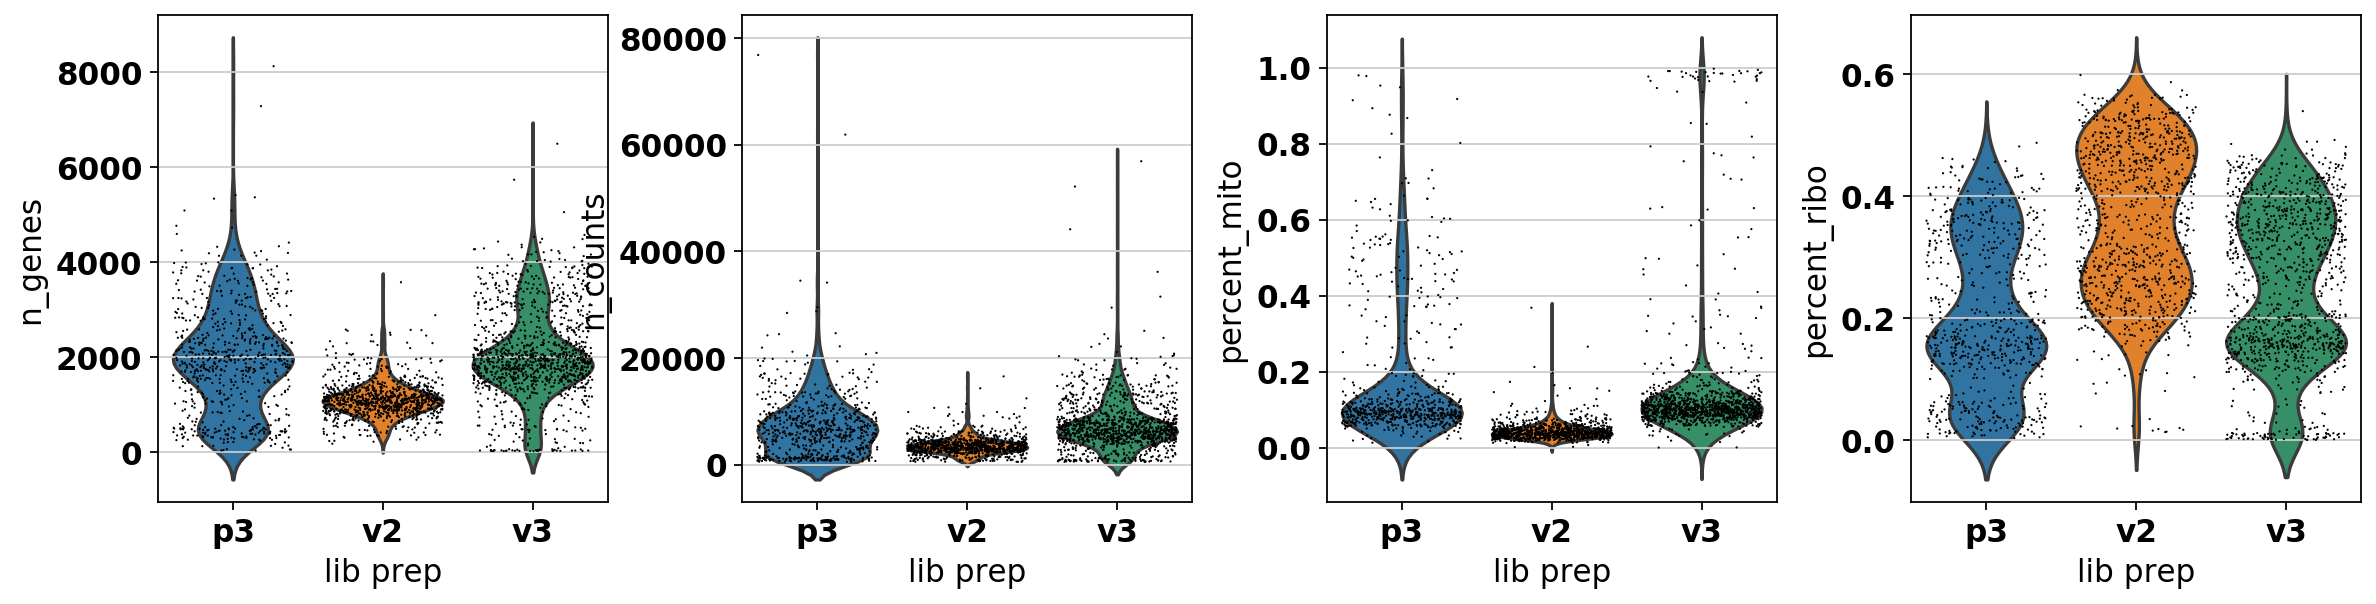

In [160]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito','percent_ribo'],
             jitter=0.4, groupby = 'lib_prep')

{{ l("QC",text,"ALL4")[0] }}

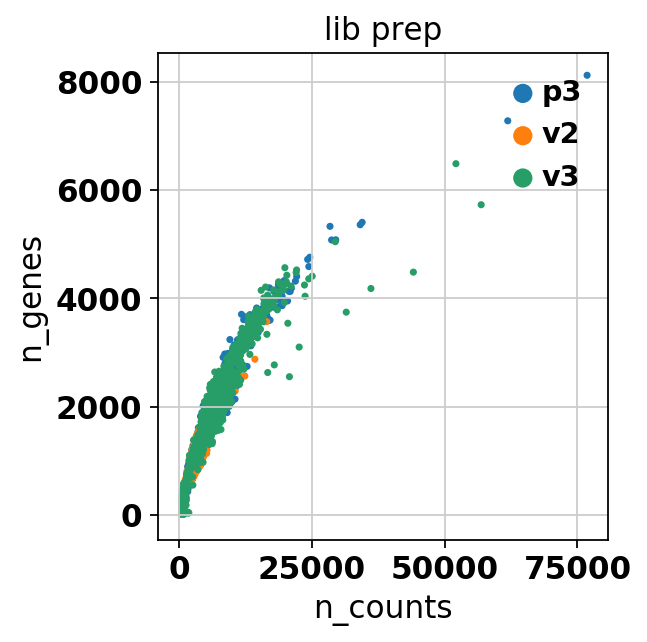

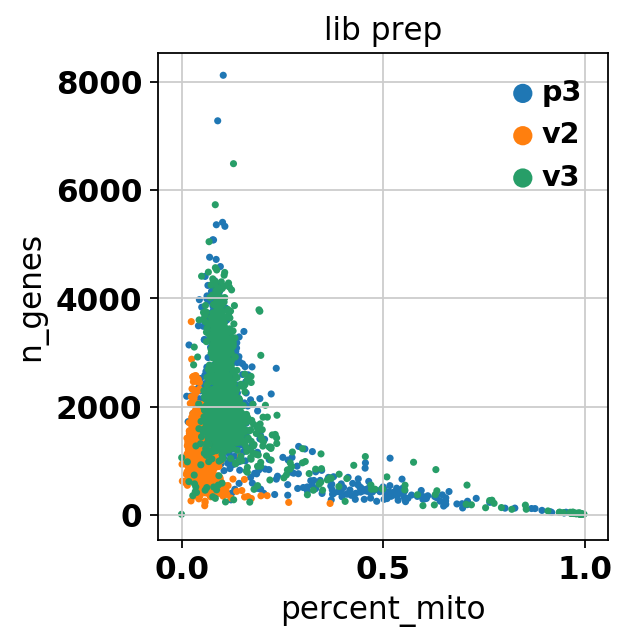

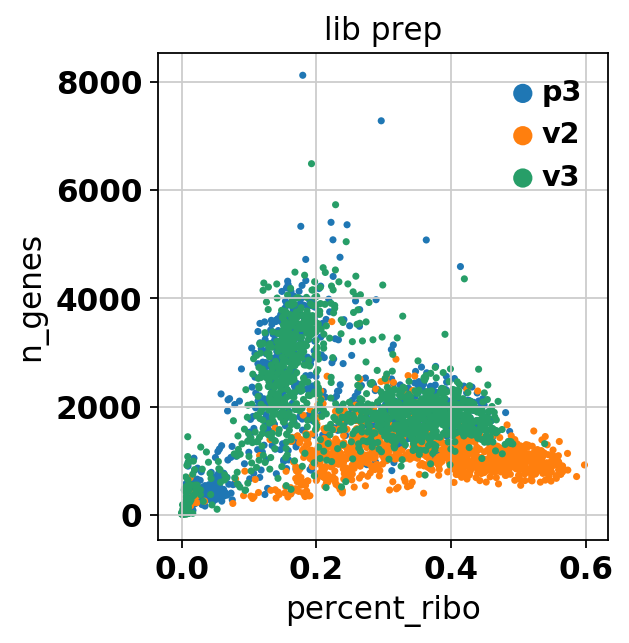

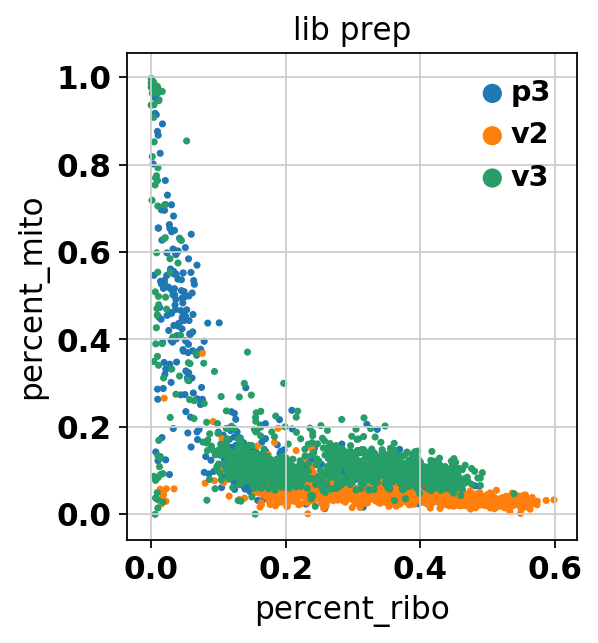

In [161]:
sc.pl.scatter(adata, x='n_counts', y='n_genes', color="lib_prep",legend_loc='upper right',show=False)
sc.pl.scatter(adata, x='percent_mito', y='n_genes', color="lib_prep",legend_loc='upper right',show=False)
sc.pl.scatter(adata, x='percent_ribo', y='n_genes', color="lib_prep",legend_loc='upper right',show=False)
sc.pl.scatter(adata, x='percent_ribo', y='percent_mito', color="lib_prep",legend_loc='upper right',show=False)

***

# {{ l("FILTERING",text,"TITLE")[0] }}

## {{ l("FILTERING",text,"TITLE1")[0] }}

{{ l("FILTERING",text,"ALL0")[0] }}

In [162]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

{{ l("FILTERING",text,"ALL3")[0] }}

In [163]:
# filter for gene detection for v2
keep_v2 = (adata.obs['n_genes'] < 2000) & (adata.obs['n_genes'] > 500) & (adata.obs['lib_prep'] == 'v2')
print(sum(keep_v2))

# filter for gene detection for v3
keep_v3 = (adata.obs['n_genes'] < 4100) & (adata.obs['n_genes'] > 1000) & (adata.obs['lib_prep'] != 'v2')
print(sum(keep_v3))

# keep both sets of cells
keep = (keep_v2) | (keep_v3)
print(sum(keep))
adata = adata[keep, :]

933
1608
2541


{{ l("FILTERING",text,"ALL01")[0] }}

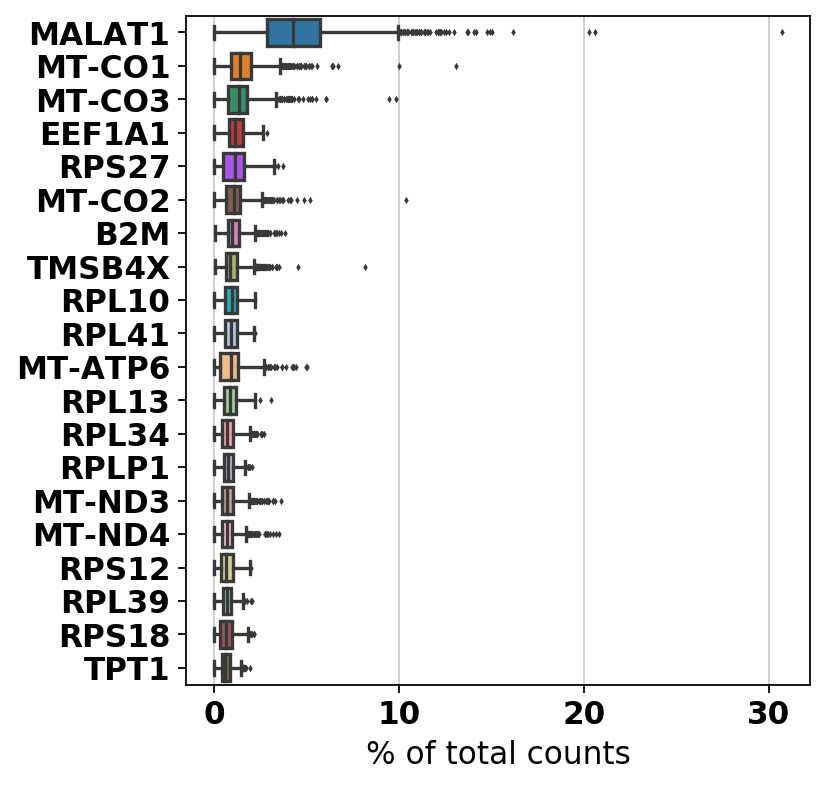

In [164]:
sc.pl.highest_expr_genes(adata, n_top=20)

{{ l("FILTERING",text,"ALL02")[0] }}

## {{ l("FILTERING",text,"TITLE2")[0] }}

{{ l("FILTERING",text,"ALL1")[0] }}

In [165]:
# filter for percent mito
adata = adata[adata.obs['percent_mito'] < 0.25, :]
adata = adata[adata.obs['percent_ribo'] > 0.05, :]

{{ l("FILTERING",text,"ALL2")[0] }}

{{ l("FILTERING",text,"ALL2")[0] }}

## {{ l("FILTERING",text,"TITLE4")[0] }}

{{ l("FILTERING",text,"ALL5")[0] }}

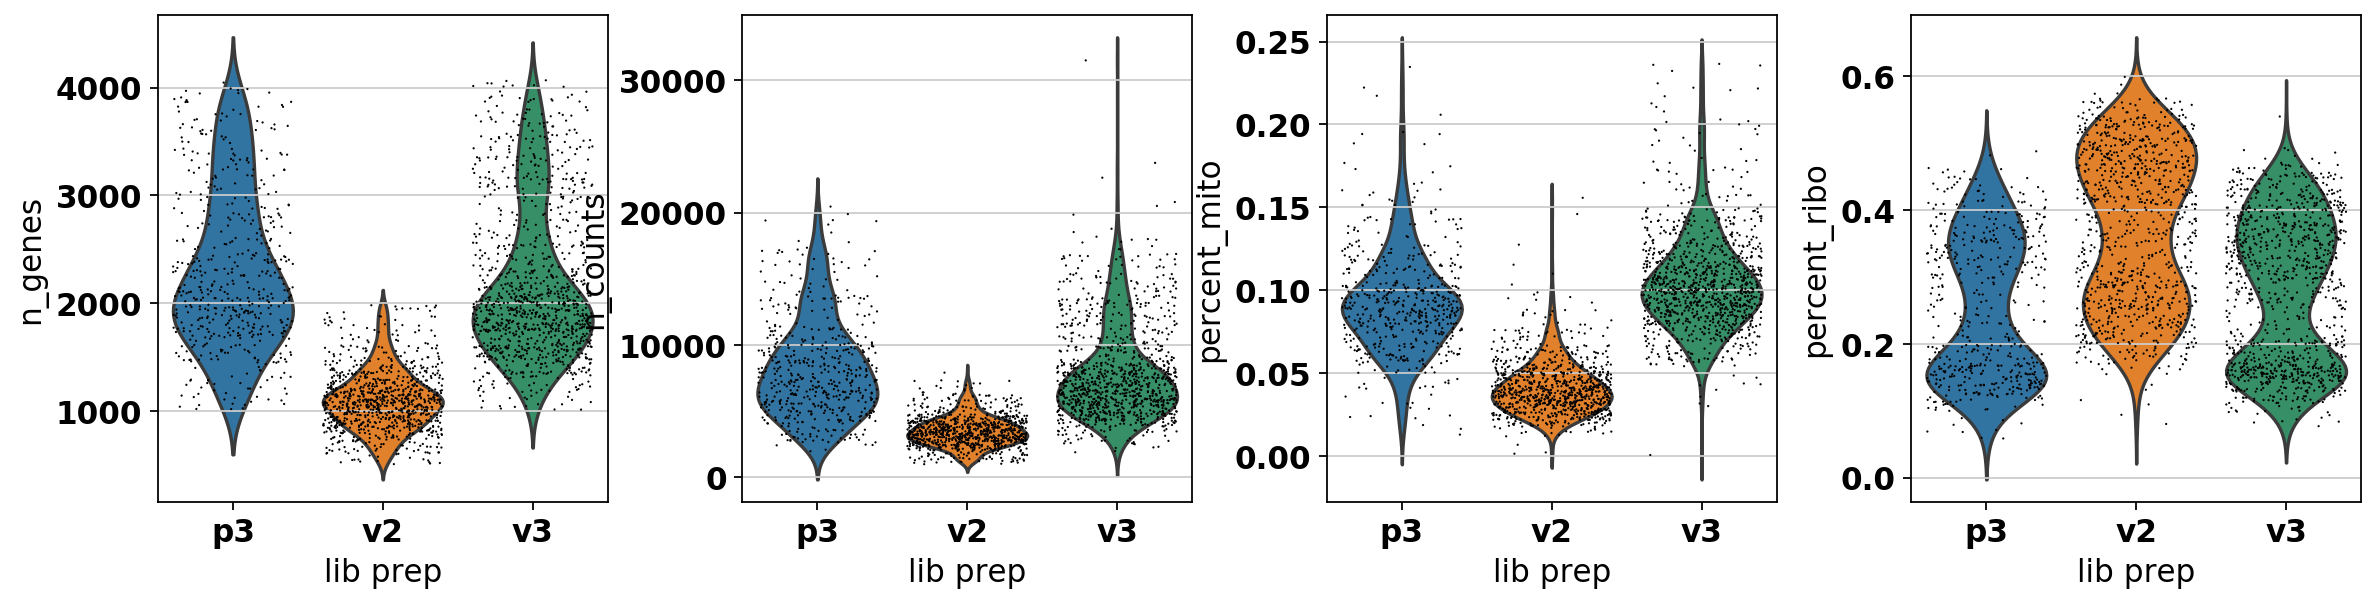

In [166]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito','percent_ribo'],
             jitter=0.4, groupby = 'lib_prep')

## {{ l("CELLCYCLE",text,"TITLE")[0] }}

{{ l("CELLCYCLE",text,"ALL1")[0] }}

{{ l("CELLCYCLE",text)[0] }}

In [167]:
response = requests.get('https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt')
cell_cycle_genes = re.split("\n",response.text)

# Split into 2 lists
s_genes = cell_cycle_genes[ :43 ]
g2m_genes = cell_cycle_genes[ 43: ]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

{{ l("CELLCYCLE",text,"ALL2")[0] }}

... storing 'phase' as categorical


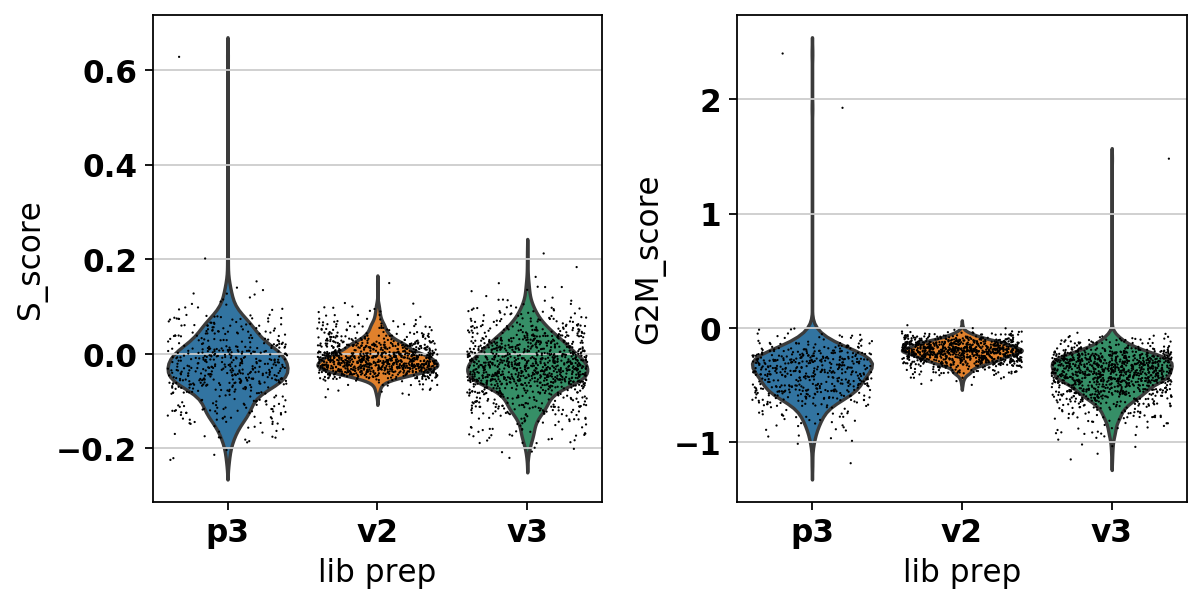

In [168]:
sc.pl.violin(adata, ['S_score', 'G2M_score'], jitter=0.4, groupby = 'lib_prep')

{{ l("CELLCYCLE",text,"ALL3")[0] }}

{{ l("CELLCYCLE",text,"ALL4")[0] }}

In [169]:
save_file = './data/qc_filtered_3pbmc.h5ad'
adata.write_h5ad(save_file)